## **classifying Tweets using: NLP**



In [ ]:
! pip install Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# We can use counter to count the objects from collections
import collections
from collections import Counter
from nltk.stem import WordNetLemmatizer

In [ ]:
import pickle

In [ ]:
import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize
# Lemmatizer helps to reduce words to the base formfrom nltk.stem import WordNetLemmatizer
# Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
SEED = 10

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
#data shape
print('Train Shape',df_train.shape)
print('Test Shape',df_test.shape)

Train Shape (7613, 5)
Test Shape (3263, 4)


#Get Head and info about the data

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


##Check For Null Data

In [ ]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
percent_missing

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [ ]:
df_train.dropna(inplace=True)

In [ ]:
percent_missing = df_test.isnull().sum() * 100 / len(df_train)
percent_missing

id           0.000000
keyword      0.511811
location    21.751969
text         0.000000
dtype: float64

In [ ]:
df_test.dropna(inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 15 to 3250
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2158 non-null   int64 
 1   keyword   2158 non-null   object
 2   location  2158 non-null   object
 3   text      2158 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.3+ KB


# EDA

In [ ]:
df_train.describe()

,id,target
count,5080.000000,5080.000000
mean,5407.112598,0.432283
std,3116.359041,0.495442
min,48.000000,0.000000
25%,2728.750000,0.000000
50%,5360.500000,0.000000
75%,8086.000000,1.000000
max,10833.000000,1.000000


Show distribution using pie chart

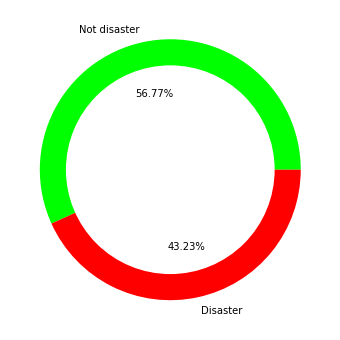

In [ ]:
# Visualising distribution of observations among categories

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    df_train["target"].value_counts(),
    autopct = "%.2f%%",
    labels = ["Not disaster", "Disaster"],
    colors = ["#00ff00", "#ff0000"]
)

# Creates circle
circle = plt.Circle((0,0), 0.80,fc='white')

# Adds circle object to the existing figure (pie chart)
fig = plt.gcf()
fig.gca().add_artist(circle)

plt.show()


let's have a look at length of each tweets


[Text(0, 0.5, '( Number of Observations )'),
 Text(0.5, 0, '( Number of Tokens )')]

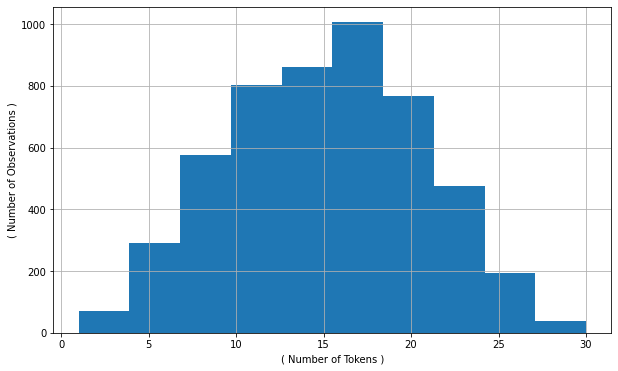

In [ ]:
# Plotting histogram for number of tokens in each observation
ax1 = df_train.text.str.split().map(lambda x: len(x)).hist(figsize=(10, 6))
ax1.set(xlabel="( Number of Tokens )", ylabel="( Number of Observations )")

**Most** tweets have between 15 to 18 tokens

Another look using box plot

Text(0, 0.5, '( Number of Tokens )')

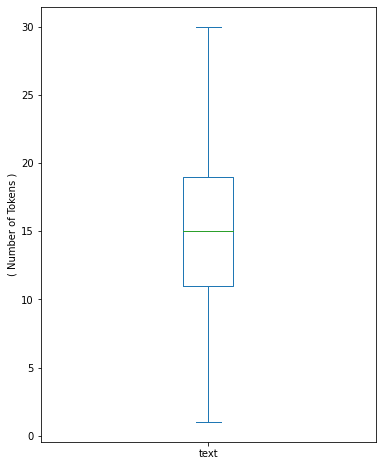

In [ ]:
# Plotting boxplot for number of tokens in each observation
ax2 = df_train.text.str.split().map(lambda x: len(x)).plot.box(figsize=(6,8))
ax2.set_ylabel("( Number of Tokens )")

the data reange more between 25% to 75% (1 st and 3 rd quartiles and no outliers found)

**Define word cloud to get frequency of words**

In [ ]:
def preprocess_tweets(df_series):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        
    Returns: 
        df_series (pd.series): Preprocessed series object. 
    """
    
    # Removes '@user' tags
    df_series = df_series.str.replace("@user", "", regex=False)
    
    # Removes non alphanumeric characters
    df_series = df_series.str.replace("[^a-zA-Z0-9 ]", " ")
    return df_series
    

def tokenize(sentence, remove_stopwords=False):
    """ Tokenizes given sentence.
        
    Args:
        sentence (str): Sentence to be tokenized
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        tokens (list): Tokenized array
    """
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = sentence.split()
        tokens = [token for token in tokens if not token.lower() in stop_words]
        return tokens
        
    return sentence.split()
    

def create_corpus(df_series, remove_stopwords=False):
    """ Creates preprocessed, lemmatized word corpus from pandas series.
        
    Args:
        df_series (pd.series): Pandas series object containing tweets.
        remove_stopwords (bool): removes stop words if set True. Defaults to False.
        
    Returns: 
        corpus (list): Tokenized, Lemmatized word corpus. 
    """
    
    corpus = []
    lm = WordNetLemmatizer()
    df_series = preprocess_tweets(df_series)
    
    for tweet in df_series:
        corpus.extend([lm.lemmatize(word) for word in tokenize(tweet, remove_stopwords=remove_stopwords)])
    
    return corpus
    

non_disaster_corpus = create_corpus(df_train[df_train["target"]==0].text, remove_stopwords=True)
disaster_corpus = create_corpus(df_train[df_train["target"]==0].text, remove_stopwords=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
def plot_word_cloud(corpus):
    """ Creates and plots the word cloud from word corpus.
        
    Args:
        corpus (list): word corpus containing all the tokens.
        
    Returns: Nothing
    
    """
    
    # creates word cloud
    word_cloud = WordCloud(
        max_words = 100,
        max_font_size = 50,
        collocations = False
    ).generate(str(corpus))
    
    # plots word cloud
    fig = plt.figure(figsize=(13, 13))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.plot()

Word Cloud for non disaster

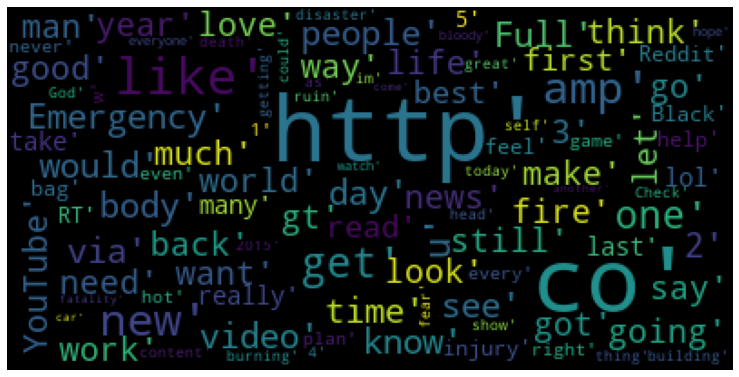

In [ ]:
plot_word_cloud(non_disaster_corpus)

word cloud for disaster

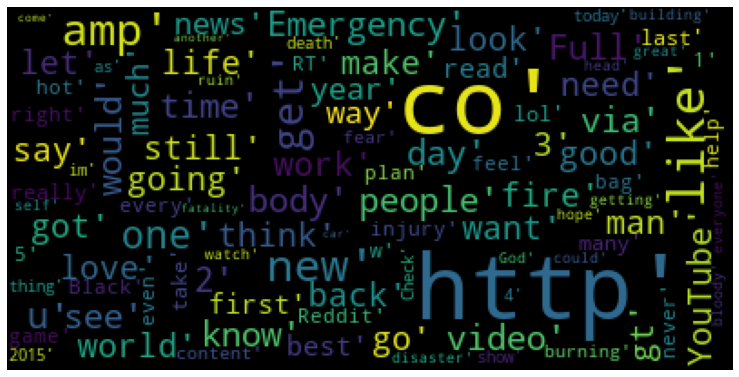

In [ ]:
plot_word_cloud(disaster_corpus)

**Visualizing top mentioned hashtags under each category**

Let's explore hashtags under each class

In [ ]:
import re

In [ ]:
def get_hash_tags(df_series):
    """ Collects all hash tags from a given pandas series.
    
    Args:
        df_series (pd.Series): Pandas series object containing text data.
    
    Returns:
        hash_tags (list): List of hash tags from the pandas series.
    """
    
    hash_tags = []
    for text in df_series:
        hash_tags.extend(re.findall(r'#(\w+)', text))
        
    return hash_tags

In [ ]:
non_disaster_hashtags = get_hash_tags(df_train[df_train["target"]==0]["text"])
disaster_hashtags = get_hash_tags(df_train[df_train["target"]==1]["text"])

In [ ]:
# disaster_hashtags

Let's graph word cloud for each

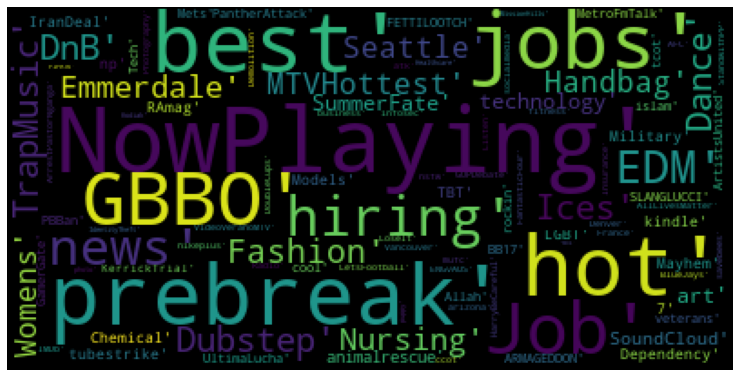

In [ ]:
plot_word_cloud(non_disaster_hashtags)

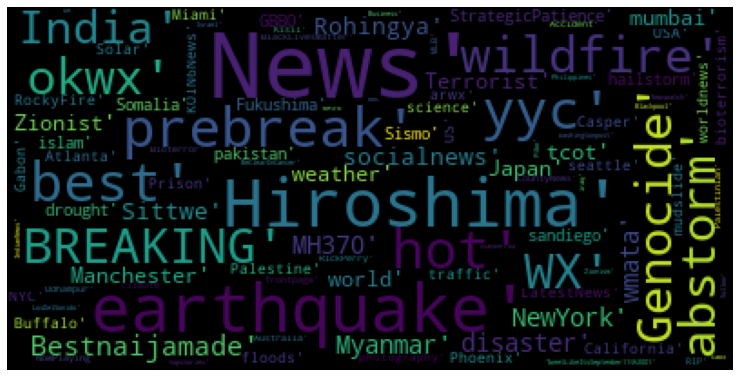

In [ ]:
plot_word_cloud(disaster_hashtags)

Let's count for each

In [ ]:
# Count of each hashtags
non_disaster_hashtags_count = Counter(non_disaster_hashtags)
disaster_hashtags_count = Counter(disaster_hashtags)

In [ ]:
# non_disaster_hashtags_count

create dataframe for counting

In [ ]:
# Creating hashtag counts DataFrame for easy manipulation and visualization

non_disaster_hashtags_count_df = pd.DataFrame.from_dict(non_disaster_hashtags_count, orient="index").reset_index()
non_disaster_hashtags_count_df.columns = ["hashtag", "count"]
non_disaster_hashtags_count_df.sort_values("count", ascending=False, inplace=True)
display(non_disaster_hashtags_count_df.head())

disaster_hashtags_count_df = pd.DataFrame.from_dict(disaster_hashtags_count, orient="index").reset_index()
disaster_hashtags_count_df.columns = ["hashtag", "count"]
disaster_hashtags_count_df.sort_values("count", ascending=False, inplace=True)
display(disaster_hashtags_count_df.head())

,hashtag,count
543,hot,16
545,best,16
544,prebreak,16
159,GBBO,12
4,NowPlaying,10


,hashtag,count
52,News,21
91,Hiroshima,13
486,hot,9
19,news,9
487,prebreak,9


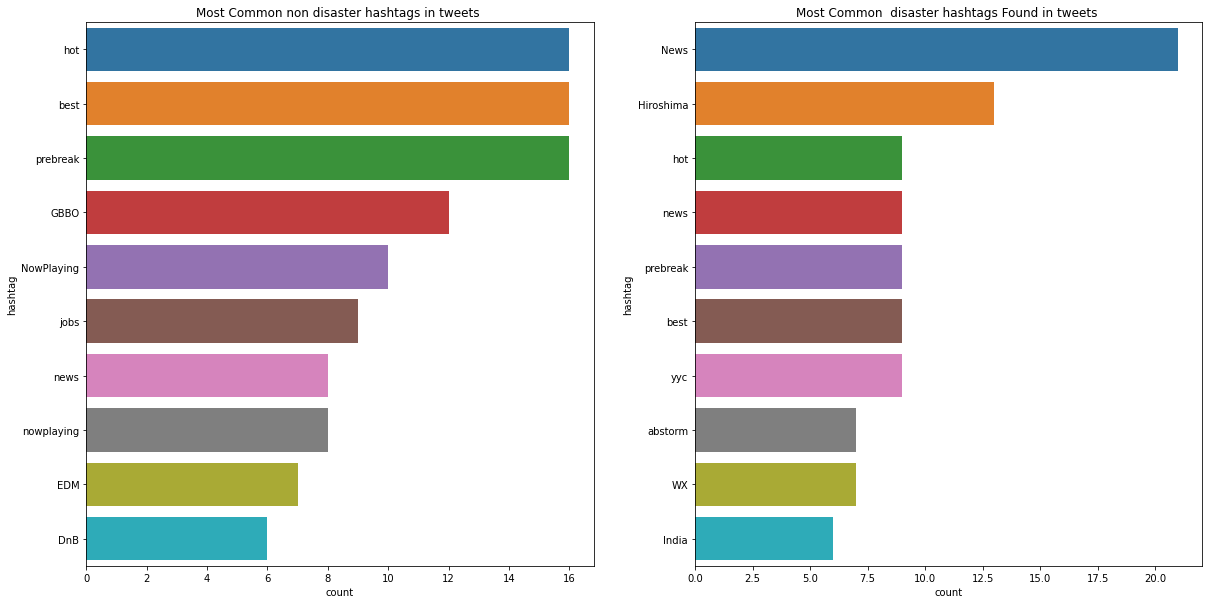

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.barplot(ax=axes[0],x='count',y='hashtag',data=non_disaster_hashtags_count_df.head(10))
sns.barplot(ax=axes[1],x='count',y='hashtag',data=disaster_hashtags_count_df.head(10))
axes[0].title.set_text('Most Common non disaster hashtags in tweets ')
axes[1].title.set_text('Most Common  disaster hashtags Found in tweets ')

Get proption of the tweets with hashtags

In [ ]:
def count_rows_with_hashtag(df_series):
    """ Counts the number of rows containing at least one hashtag (#example).
    
    Args:
        df_series (pd.Series): Pandas series containing text data.
        
    Returns:
        count (int): Count of number of rows containing at least one hashtag.
    """
    
    count = 0
    for tweet in df_series:
        if re.search(r'#(\w+)', tweet):
            count+=1
    
    return count

Get the pie chart to this propotion

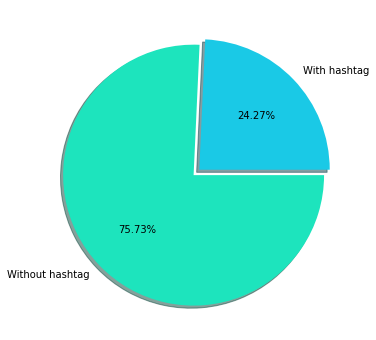

In [ ]:
hashtag_tweet_count = count_rows_with_hashtag(df_train["text"])

train_rows, train_cols = df_train.shape

plt.figure(figsize=(6, 6))

# Creates pie chart
plt.pie(
    [hashtag_tweet_count, train_rows-hashtag_tweet_count],
    autopct = "%.2f%%",
    labels = ["With hashtag", "Without hashtag"],
    explode = [0, 0.06],
    shadow = True,
    colors = ["#1AC9E6", "#1DE4BD"]
)

plt.show()

**Conclution**

1 - Most of tweets contain Hashtags

2- words like good, way,like are the most famous in the 
positive tweets while they appear also in the disaster that may indicate that may be collected again

3- data is balanced 54% is class disaster // 46% non disaster

4- 75% of data contain hashtags while 25 non 

5- Most common non disaster hashtags is hot ,best etc ..  
while disaster news , hiroshima 

6- jobs is represented in positive hashtags so it may indicate that social media is used to gather jobs

**As though from seeing the header data for train dataframe and test dataframe the most percentage of missing data is found in location data**

In [ ]:
seriesf = df_train.groupby(['target'])['target'].count()
DF_target = pd.DataFrame({'Class':seriesf.index, 'Count':seriesf.values})

In [ ]:
DF_target

,Class,Count
0,0,2884
1,1,2196


In [ ]:
count_sum = DF_target['Count'].sum()

In [ ]:
mean_dict = {}

for i in range(len(DF_target)):
  mean_dict[DF_target['Class'][i]]=(DF_target['Count'][i]/count_sum)*100

In [ ]:
mean_dict

{0: 56.77165354330709, 1: 43.22834645669291}

Funnel-Chart for visualization

In [ ]:
from plotly import graph_objs as go

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =DF_target.Class,
    values = DF_target.Count,
    title = {"position": "top center", "text": "Funnel-Chart of Class Distribution"}
    ))
fig.show()

##Check Data in Location/KeyWord Column

**This Means that the text about the real disaster which has the class 1 is 42% in the train data and for not disaster is 57% of the train data is in that class**

**Getting the 15 highest Location Found in data**

In [ ]:
df_train.groupby(['location'])['location'].count().sort_values(ascending=False)[0:15]

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
Name: location, dtype: int64

***It is noticed that USA has the highest existence in data of location as seen(USA, New York, United States,....) 
this data may be baised more for the American Society mind***

**Getting the 15 highest Keywords**

In [ ]:
df_train.groupby(['keyword'])['keyword'].count().sort_values(ascending=False)[0:15]

keyword
collision           36
whirlwind           33
armageddon          32
fatalities          32
flames              31
emergency%20plan    31
derailed            31
outbreak            31
sandstorm           31
danger              30
inundated           30
harm                30
damage              30
desolation          30
upheaval            30
Name: keyword, dtype: int64

##Get the distribution for the target Labels

Text(0.5, 1.0, 'Distribution of the Target Label')

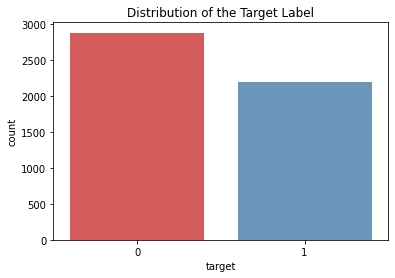

In [ ]:
sns.countplot(x = df_train['target'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the Target Label')

In [ ]:
def word_frequency(sentence):
  # joins all the sentenses
  sentence ="".join(sentence)
  # creates tokens, creates lower class, removes numbers and lemmatizes the words
  new_tokens = word_tokenize(sentence)
  new_tokens = [t.lower() for t in new_tokens]
  new_tokens_word =[t for t in new_tokens if t not in stopwords.words('english')]
  new_tokens_stword =[t for t in new_tokens if t in stopwords.words('english')]
  new_tokens_word = [t for t in new_tokens_word if t.isalpha()]
  new_tokens_stword = [t for t in new_tokens_stword if t.isalpha()]
  lemmatizer = WordNetLemmatizer()
  new_tokens_word =[lemmatizer.lemmatize(t) for t in new_tokens_word]
  new_tokens_stword = [lemmatizer.lemmatize(t) for t in new_tokens_stword]
  #counts the words, pairs and trigrams for both words and stop words
  counted = Counter(new_tokens_word)
  counted_stp = Counter(new_tokens_stword)
  #create data frequency dataframe
  word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  word_freq_stp = pd.DataFrame(counted_stp.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
  return word_freq,word_freq_stp

In [ ]:
a = word_frequency(df_train['text'])

In [ ]:
a[0]

,word,frequency
4,http,3121
118,like,229
141,amp,216
148,fire,205
64,get,170
...,...,...
5410,compelling,1
5409,convincing,1
5408,msmigot,1
5406,housetwitter,1


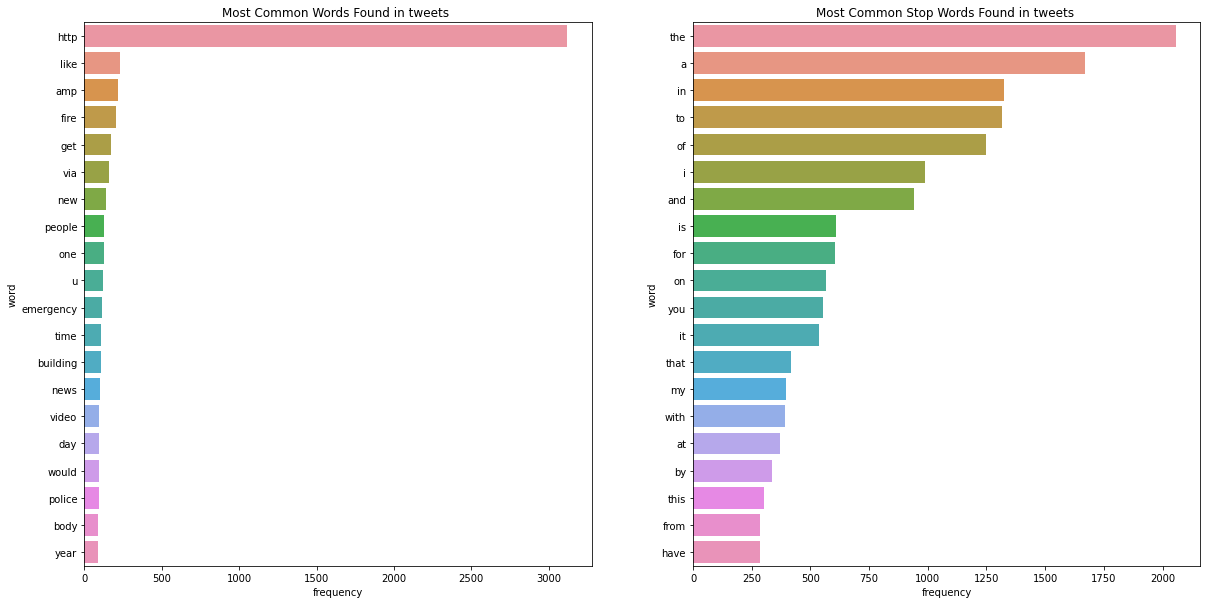

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.barplot(ax=axes[0],x='frequency',y='word',data=a[0].head(20))
sns.barplot(ax=axes[1],x='frequency',y='word',data=a[1].head(20))
axes[0].title.set_text('Most Common Words Found in tweets ')
axes[1].title.set_text('Most Common Stop Words Found in tweets ')

**As found the word "http" is the most common word found in the normal word which may give an indication that there are about tweets that contain links for some content -- the other is that the tweets contain low frequency of normal words in compare to stop words**

##Define Our Model

In [ ]:
df_train.dropna(subset = ['text'], inplace = True)

X = df_train['text']
y = df_train['target']

**Define LSTM model**

In [ ]:
def get_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[MAX_LEN]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    #compile model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

**Divide data to train and test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [ ]:
#define Keras Tokenizer
MAX_LEN = 50

tok = Tokenizer()
tok.fit_on_texts(X_train)
#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)
#padded sequences
X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)

#create the model
model = get_model()

In [ ]:
import torch

In [ ]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
#train model
history = model.fit(X_train_seq, y_train, epochs=50,
                    validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=6, verbose=False,restore_best_weights=True)])


In [ ]:
y_pred =  model.predict(X_test_seq)

In [ ]:
y_pred

In [ ]:
y_pred = np.where(y_pred>=0.5,1,0)

In [ ]:
y_pred

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
y_test

7081    1
2183    1
497     0
1915    0
1228    1
       ..
5928    0
6132    0
6160    1
536     0
920     0
Name: target, Length: 1523, dtype: int64

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       869
           1       0.75      0.74      0.75       654

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



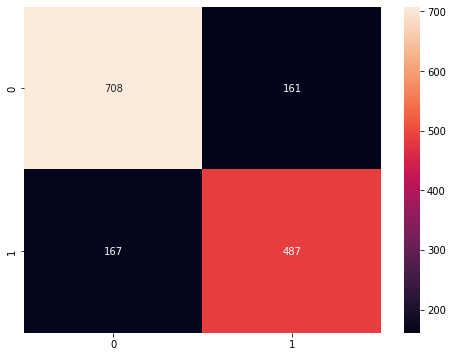

In [ ]:
#confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='')

##Pickling Model Weights

In [ ]:
weigh= model.get_weights();    pklfile= "/content/modelweights.pkl"
try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(weigh, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()

In [ ]:
# with open(r"/etc/modelweights.pkl", "rb") as input_file:
#        e = pickle.load(input_file)

In [ ]:
# e